---
## Unrepräsentative Daten (Experiment)
by Tobia Ippolito
### Contents:
- [Beschreibung](#Beschreibung)
- [Imports](#Imports)
- [Experiment](#Experiment)
- [Experiment 2](#Experiment_2_(andere_personenkonstellation))
- [Ergebnis](#Ergebnis)

<br>
<br>

---

### Beschreibung
Es soll getestet werden, ob manche Personenkonstellationen einfach sehr schwer zu unterscheiden sind oder ob die Trainingsdaten daran schuld sind (zu wenig Trainingsdaten oder Trainingsdaten zu unsagekräftig).<br>
<br>

---
### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../src')

In [2]:
import anoog
from anoog.model import predict_proba
from anoog.model import train_random_forest

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import random

---
### Experiment

Load Data -> Don't touch the testdata!!!

In [5]:
train_data, test_data = anoog.io.load_data("../../data/2021-11-09",
                                ['tippolit', 'vkorzev'],
                                extraction=anoog.io.extraction_mode.MANUEL,
                                selection=anoog.io.selection_mode.NONE,
                                train_test_split=True,
                                test_size=0.3)
print("Len of Train-Data", len(test_data))
print("y-count_values Train_Data:\n", train_data['y'].value_counts()[0], train_data['y'].value_counts()[1])
print("Len of Test-Data", len(test_data))
print("y-count_values Test-Data:\n", test_data['y'].value_counts()[0], test_data['y'].value_counts()[1])
train_data.tail()

Len of Train-Data 15
y-count_values Train_Data:
 18 17
Len of Test-Data 15
y-count_values Test-Data:
 7 8


,audio_min,audio_max,audio_mean,audio_median,audio_std,current_min,current_max,current_mean,current_median,current_std,...,voltage_mean,voltage_median,voltage_std,Time,Resistance,Power,Work,mAh,Wh,y
13,-5.712891,3.422858,-0.028224,-0.014136,1.235233,-0.850208,30.270541,3.522206,4.423537,4.191823,...,19.427482,19.281837,0.555071,3.32,0.181300,68.427596,227.179618,58.703435,1140.459929,0
22,-4.444125,5.483398,0.007517,-0.001169,1.473578,-0.852568,31.765591,2.274081,2.112612,3.359422,...,19.507390,19.624449,0.448560,6.45,0.116575,44.361392,286.130978,37.901356,739.356531,0
4,-6.069336,3.519140,-0.016214,-0.003905,1.063489,-0.939453,30.711006,3.167100,3.512523,3.284618,...,19.646134,19.554157,0.452214,4.19,0.161207,62.221274,260.707139,52.785004,1037.021238,0
33,-3.785000,3.471892,-0.000660,-0.004282,1.220027,-0.845724,30.253421,3.301210,4.334497,3.845601,...,19.247490,19.104569,0.493643,3.46,0.171514,63.540007,219.848423,55.020168,1059.000111,1
32,-2.298118,4.216855,0.004788,-0.001636,0.657386,-0.866211,29.974494,2.981563,3.595562,3.377438,...,19.303159,19.202534,0.451026,4.73,0.154460,57.553586,272.228463,49.692719,959.226438,1


In [6]:
X_test, y_test = anoog.io.X_y_split(test_data)

Helper Functions (for plotting)

In [7]:
def plot_acc(acc):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    plt.style.use('seaborn-whitegrid')

    n, bins, patches = ax[0].hist(acc, bins=len(acc)//4)
    cm = plt.cm.get_cmap('RdYlBu_r')
    col = (n-n.min())/(n.max()-n.min())
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    #ax[0].hist(acc, bins=len(acc)//4)
    ax[0].grid()
    ax[0].set_title("Histogramm der Accuracy")
    ax[0].set_xlabel("Accuracy")
    ax[0].set_ylabel("Counts")

    ax[1].boxplot(acc, vert=False) 
    ax[1].grid()
    ax[1].set_title("Boxplot der Accuracy")
    ax[1].set_xlabel("Accuracy")

Experiment Function

In [8]:
def train_test_with_random_entries(model_method=train_random_forest, entry_amount_per_class=3, try_amount=100):
    acc = []
    for i in range(try_amount):
        # collect 3 random data-entries per class
        indexes = []
        for count in range(entry_amount_per_class):
            # get y = 0
            while True:
                new_value = random.randint(0, len(train_data)-1)
                if new_value not in indexes and train_data.iloc[new_value].y == 0:
                    break
            indexes += [new_value]

            # get y = 1
            while True:
                new_value = random.randint(0, len(train_data)-1)
                if new_value not in indexes and train_data.iloc[new_value].y == 1:
                    break
            indexes += [new_value]

        local_train_data = train_data.iloc[indexes]
        X_train, y_train = anoog.io.X_y_split(local_train_data)

        # train model
        model = model_method(X_train, y_train, auto_params=False, normalize=True)

        # predict predict_data, X_train, normalize=False)
        #result = anoog.predict_proba(model, X_test, X_train, normalize=True)
        result = anoog.model.evaluate_model(model, X_test, y_test, local_train_data.drop(columns=['y']), normalize=True)
        acc += [result[0]]

    result_str = f"Info:\n  Traindata-Amount: {entry_amount_per_class*2} ({entry_amount_per_class} per class)"
    result_str += f"\n  Mean of {try_amount} predictions and shuffles.\n  Model:{model_method.__name__}"
    result_str += f"\n\nAccuracy:\n  Mean: {round(np.mean(acc), 2)}%, Median: {round(np.median(acc),2)}%"
    result_str += f"\n  Min: {round(np.min(acc),2)}%, Max: {round(np.max(acc),2)}%\n  Variance: {round(np.std(acc),2)}"
    print(result_str)
    plot_acc(acc)

Testing/Execute Experiment

Info:
  Traindata-Amount: 6 (3 per class)
  Mean of 50 predictions and shuffles.
  Model:train_svc

Accuracy:
  Mean: 64.67%, Median: 66.67%
  Min: 46.67%, Max: 80.0%
  Variance: 6.96


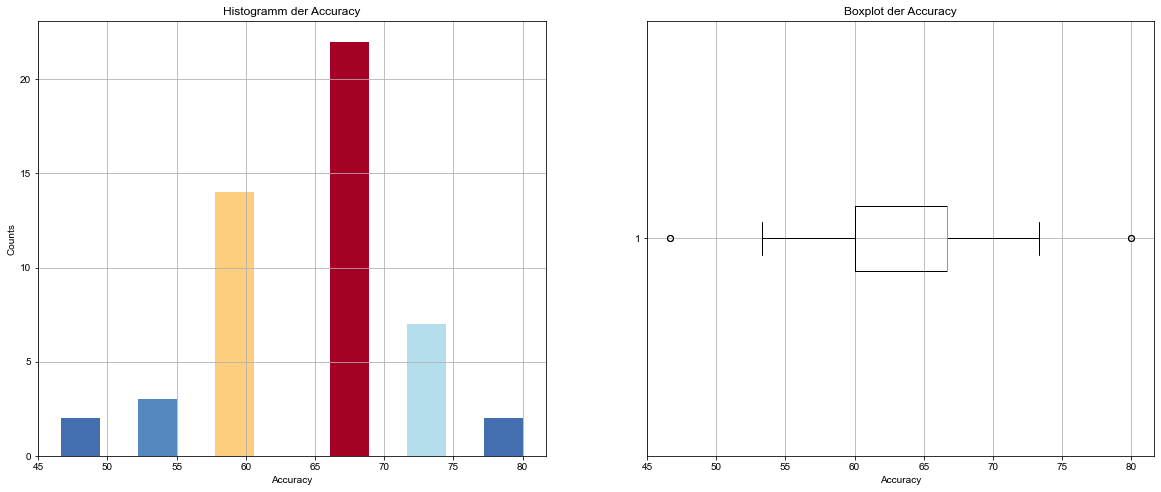

In [9]:
train_test_with_random_entries(model_method=anoog.model.train_svc, entry_amount_per_class=3, try_amount=50)

Info:
  Traindata-Amount: 6 (3 per class)
  Mean of 50 predictions and shuffles.
  Model:train_random_forest

Accuracy:
  Mean: 68.8%, Median: 66.67%
  Min: 53.33%, Max: 93.33%
  Variance: 9.09


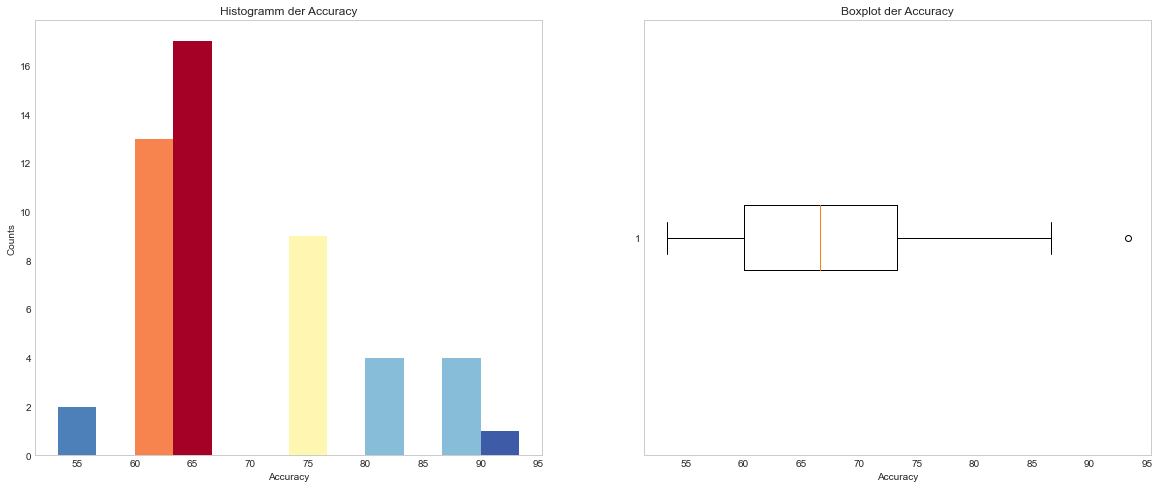

In [10]:
train_test_with_random_entries(model_method=anoog.model.train_random_forest, entry_amount_per_class=3, try_amount=50)

---
### Experiment 2 (andere personenkonstellation)

Load Data

In [11]:
train_data, test_data = anoog.io.load_data("../../data/2021-11-09",
                                ['tippolit', 'skadkade'],
                                extraction=anoog.io.extraction_mode.MANUEL,
                                selection=anoog.io.selection_mode.NONE,
                                train_test_split=True,
                                test_size=0.3)
print("Len of Train-Data", len(test_data))
print("y-count_values Train_Data:\n", train_data['y'].value_counts()[0], train_data['y'].value_counts()[1])
print("Len of Test-Data", len(test_data))
print("y-count_values Test-Data:\n", test_data['y'].value_counts()[0], test_data['y'].value_counts()[1])

Len of Train-Data 15
y-count_values Train_Data:
 18 17
Len of Test-Data 15
y-count_values Test-Data:
 7 8


In [12]:
X_test, y_test = anoog.io.X_y_split(test_data)

Info:
  Traindata-Amount: 6 (3 per class)
  Mean of 50 predictions and shuffles.
  Model:train_svc

Accuracy:
  Mean: 66.93%, Median: 66.67%
  Min: 46.67%, Max: 93.33%
  Variance: 10.91


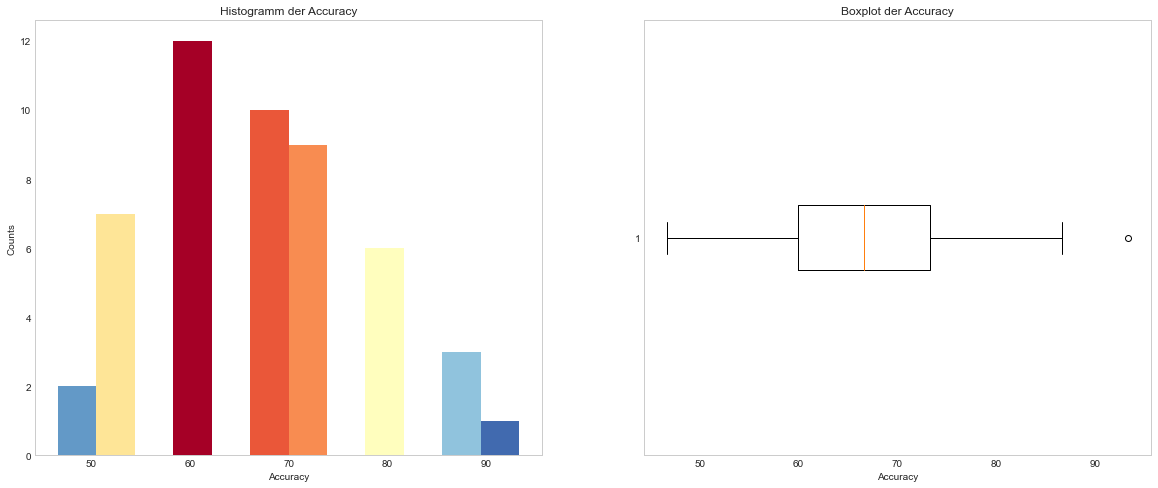

In [13]:
train_test_with_random_entries(model_method=anoog.model.train_svc, entry_amount_per_class=3, try_amount=50)

Info:
  Traindata-Amount: 6 (3 per class)
  Mean of 50 predictions and shuffles.
  Model:train_random_forest

Accuracy:
  Mean: 78.93%, Median: 80.0%
  Min: 53.33%, Max: 100.0%
  Variance: 11.65


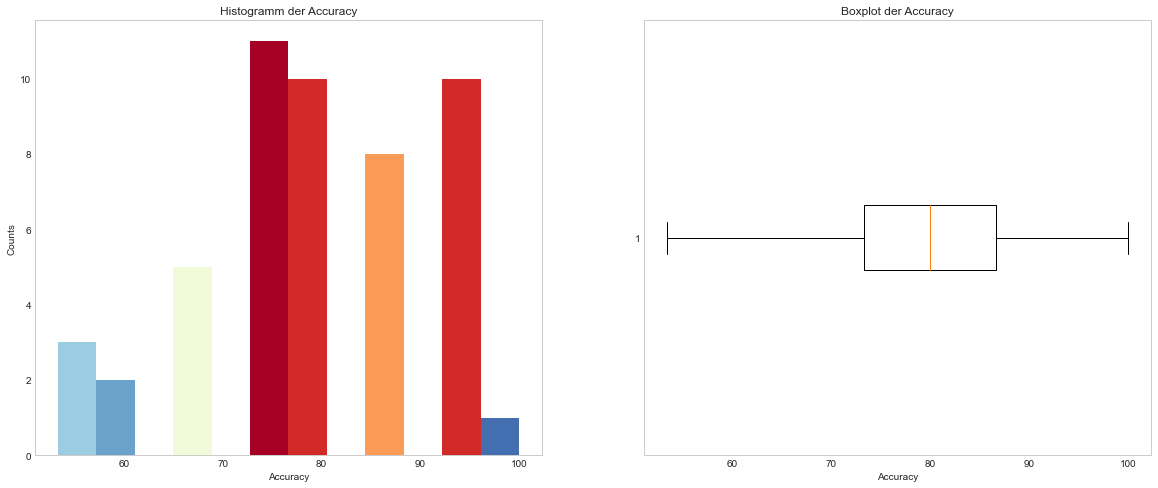

In [14]:
train_test_with_random_entries(model_method=anoog.model.train_random_forest, entry_amount_per_class=3, try_amount=50)

---
### Ergebnis

Das Experiment zeigt, dass sehr wohl ungünstige Konstellationen exsistieren, bei denen der Algorithmus kein gutes Muster für die Person generieren kann.<br>
Im Durchschnitt und im Median scheinen diese Konstellationen aber eher seltenerer Natur zu sein.<br>
<br>
Diese Ergebnisse wurden bei beiden Experimenten / Personenkonstellationen beobachtet.

---